In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is the complete data analysis report, including data retrieval, data visualization, data preparation, model construction, and model assessment. In the end, the bar chart shows the important features that need to be recorded for future implementation.

Data source:
https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

## Load data

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Redback_B/Heart_2022/heart_2022_no_nans.csv')

In [20]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

## Visualize Data

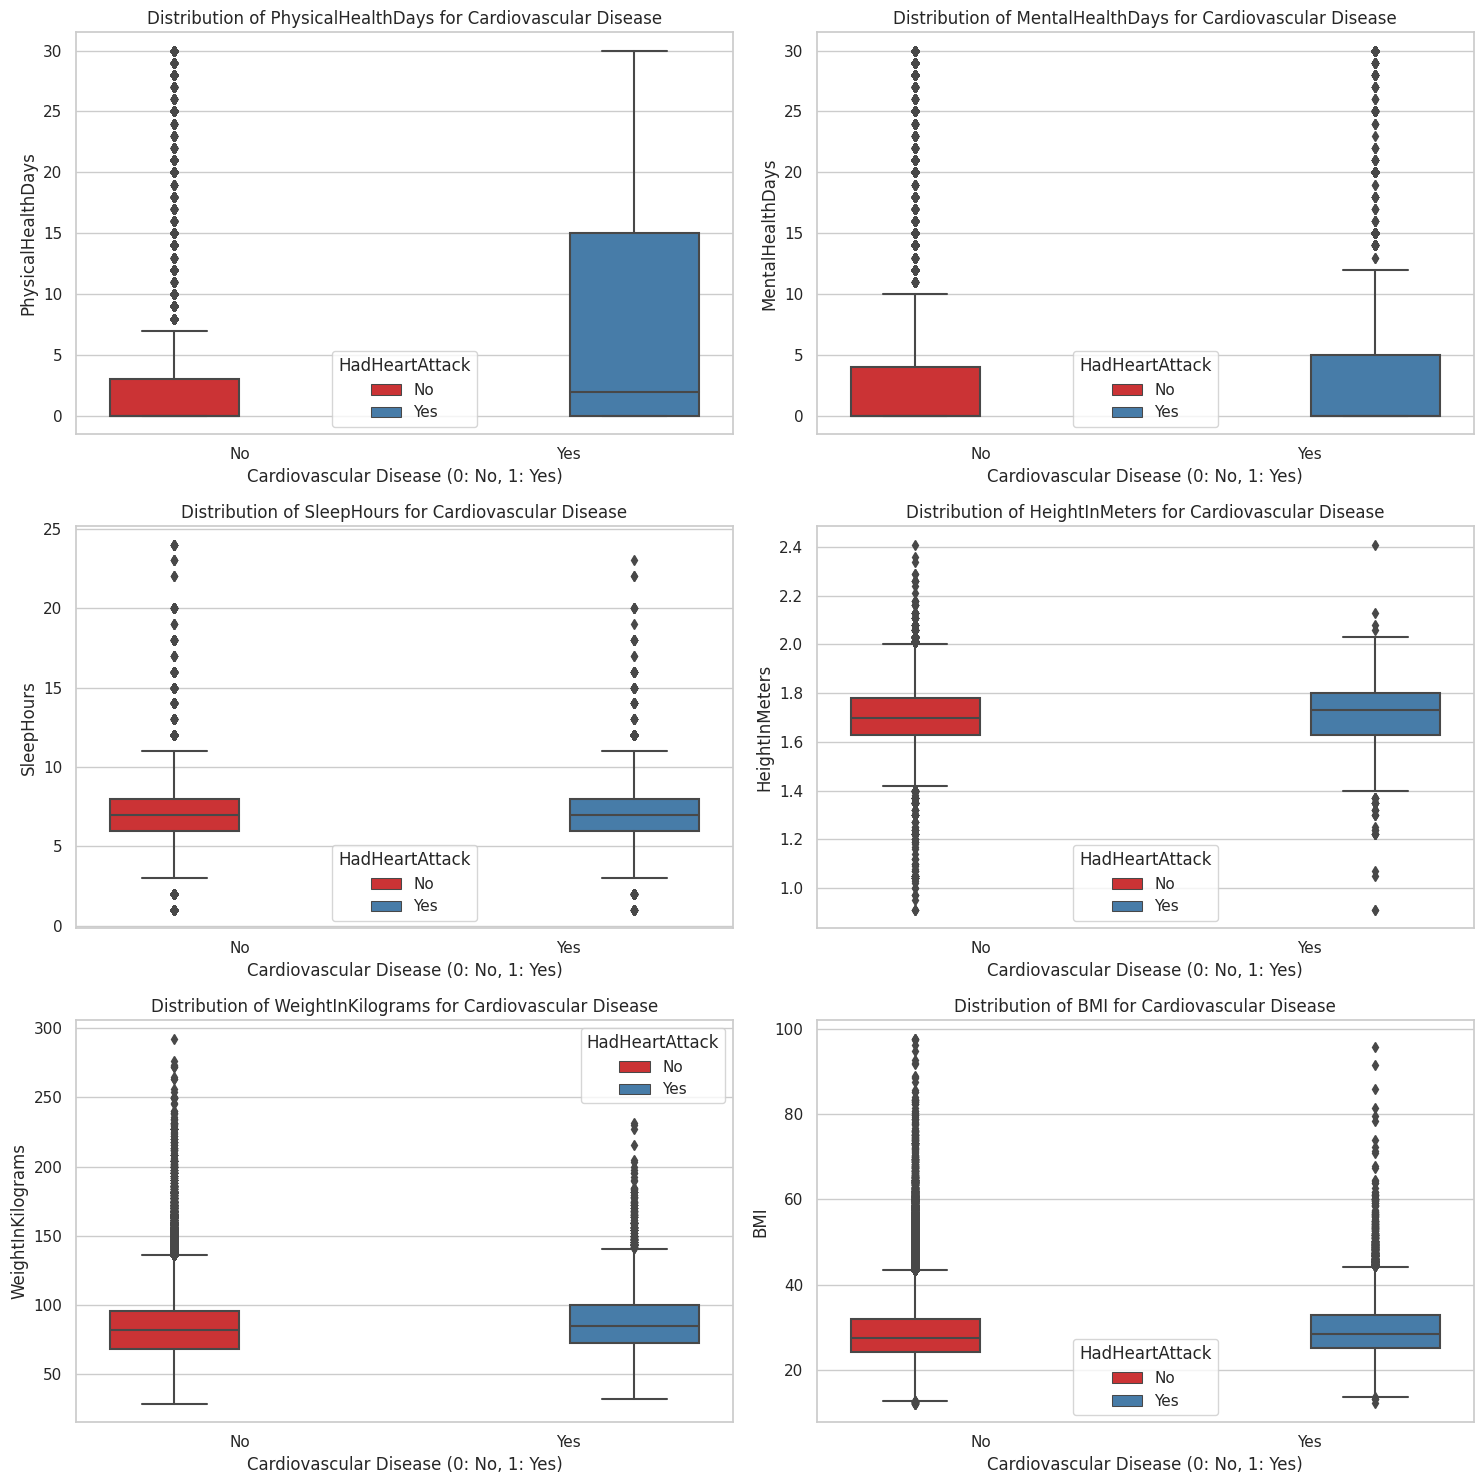

In [22]:
# Depict all numeric variables using boxplots
# Set the style of seaborn as white grid
sns.set(style="whitegrid")

# Define numeric features to plot
numeric_features = df.select_dtypes(include=['number']).columns.tolist()

# Create a boxplot for each feature
plt.figure(figsize=(15, 15))

# Define the number of rows and columns in the subplot grid
num_rows = len(numeric_features) // 2
num_cols = 2

# Loop through numeric features and create boxplots
for i, feature in enumerate(numeric_features, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='HadHeartAttack', y=feature, data=df, hue='HadHeartAttack', palette='Set1')
    plt.xlabel('Cardiovascular Disease (0: No, 1: Yes)')
    plt.ylabel(feature)
    plt.title(f'Distribution of {feature} for Cardiovascular Disease')

# Adjust layout
plt.tight_layout()
plt.show()


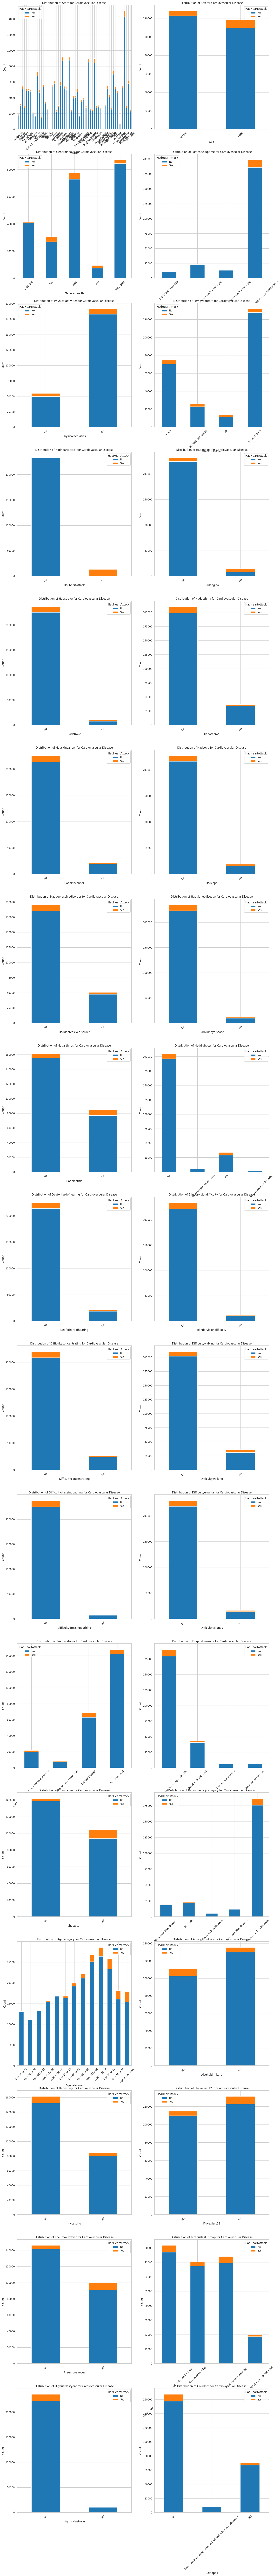

In [23]:
# Depict all categorical variables using stacked bar charts
# Create a shared ax for all subplots
fig, axes = plt.subplots(nrows=17, ncols=2, figsize=(20, 200))

# Flatten the 2D array of axes
axes = axes.flatten()

# Loop through each categorical variable
object_columns = df.select_dtypes(include=['object']).columns.tolist()
for i, categorical_var in enumerate(object_columns):
    # Count the occurrences of each combination of the categorical variable and 'cardio'
    cate_cardio_counts = df.groupby([categorical_var, 'HadHeartAttack']).size().unstack()

    # Plot a stacked bar chart
    cate_cardio_counts.plot(kind='bar', stacked=True, ax=axes[i], color=['#1f77b4', '#ff7f0e'])

    axes[i].set_xlabel(f'{categorical_var.capitalize()}')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of {categorical_var.capitalize()} for Cardiovascular Disease')
    axes[i].tick_params(axis='x', rotation=45, labelrotation=45)

plt.show()


## Prepare data

In [24]:
# Show the unique values for all object columns
# Check data imbalance of the target variable

def get_unique_values_object_columns(dataframe):
    unique_values_dict = {}
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            unique_values = dataframe[column].value_counts().reset_index()
            unique_values.columns = [column, 'Count']
            unique_values_dict[column] = unique_values
    return unique_values_dict

# Get unique values and counts
result = get_unique_values_object_columns(df)

# Print
for column, unique_values_df in result.items():
    print(f"Column: {column}")
    print(unique_values_df)
    print()

Column: State
                   State  Count
0             Washington  15000
1               Maryland   9165
2              Minnesota   9161
3                   Ohio   8995
4               New York   8923
5                  Texas   7408
6                Florida   7315
7                 Kansas   6145
8              Wisconsin   6126
9                  Maine   6013
10                  Iowa   5672
11                Hawaii   5596
12              Virginia   5565
13               Indiana   5502
14        South Carolina   5471
15         Massachusetts   5465
16               Arizona   5462
17                  Utah   5373
18              Michigan   5370
19              Colorado   5159
20              Nebraska   5107
21            California   5096
22           Connecticut   5053
23               Georgia   4978
24               Vermont   4845
25          South Dakota   4405
26               Montana   4264
27              Missouri   4195
28            New Jersey   3967
29         New Hampshire  

In [25]:
# Fix the problem of data imbalanceusing under sampling

# Split the dataset into majority class ('No') and minority class ('Yes')
df_majority = df[df['HadHeartAttack'] == 'No']
df_minority = df[df['HadHeartAttack'] == 'Yes']

fraction_to_keep = 0.4
# 0.4 is the best fraction I found after running several attempts.

# Randomly sample a portion
df_majority_sampled = df_majority.sample(frac=fraction_to_keep, random_state=42)

# Combine the two to make a balanced dataset
df_balanced = pd.concat([df_minority, df_majority_sampled])

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced.copy()

In [26]:
# Define X and y
y = df.HadHeartAttack
X = df.drop('HadHeartAttack', axis=1)

In [27]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=456)

In [28]:
# Convert target variable into numbers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [29]:
def preprocess_data(X_train, X_test):
    # Separate numerical and categorical columns
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Normalize numerical data using StandardScaler
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Apply LabelEncoder to categorical data
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])

    return X_train, X_test

X_train_processed, X_test_processed = preprocess_data(X_train.copy(), X_test.copy())

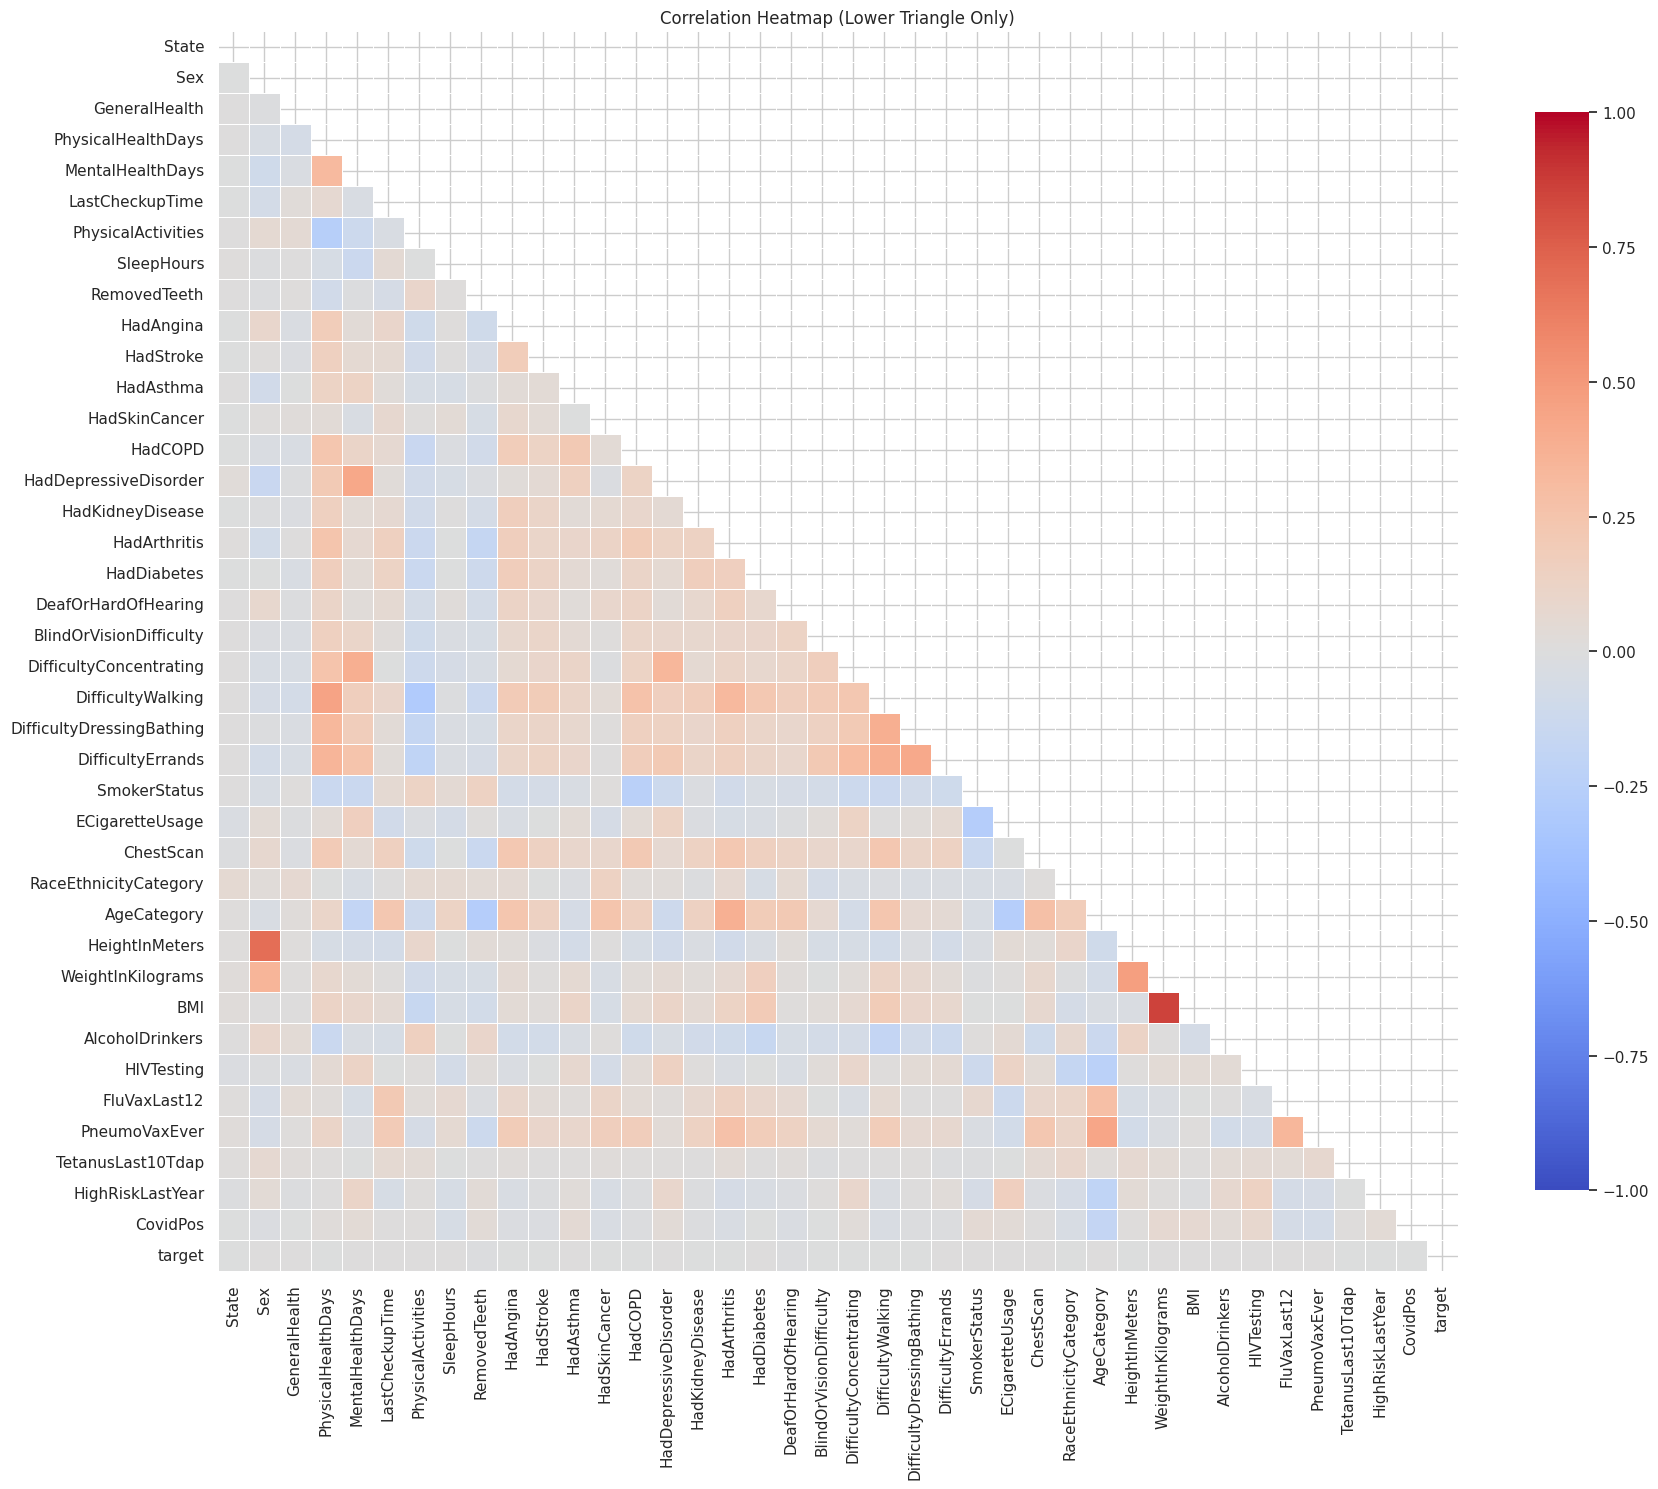

In [30]:
# Correlation matrix
corr_matrix = pd.concat([X_train_processed, pd.Series(y_train, name='target')], axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", mask=mask,
            cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

plt.title('Correlation Heatmap (Lower Triangle Only)')
plt.show()

# Physical health days and mental health days are correlated with previous health conditions

## Construct Model

AdaBoost and random forest are usually effective method to choose when there is significant data imbalance. After some research, I constructed a random forest model, using grid search and cross validation to find suitable parameters, and used the random forest as a base learner for AdaBoost model. The results of accuracy and precision are the best so far.

In [31]:
# Start the timer
start_time = time.time()

In [32]:
# Create an instance of Random Forest Classifier
rf = RandomForestClassifier()

# Set the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2']
}

# Use GridSearchCV to search for the best parameter values
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=3)
grid_search.fit(X_train_processed, y_train)

# The best parameter values
print("Best parameters: ", grid_search.best_params_)

# Use the best parameter values to create a Random Forest classifier
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Perform cross-validation on the training set
cv_scores_rf = cross_val_score(best_rf, X_train_processed, y_train, cv=3)

# Print the cross-validation scores
print("Parameter values of best_rf: ", best_rf.get_params())
print("Cross-validation scores for Random Forest:", cv_scores_rf)

Parameter values of best_rf:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Cross-validation scores for Random Forest: [0.9061305  0.90560721 0.90669404]


In [33]:
# Use the best_rf as the base learner for AdaBoost
adaboost_classifier_rf = AdaBoostClassifier(best_rf, n_estimators=50)

# Train the model
adaboost_classifier_rf.fit(X_train_processed, y_train)

# Predict
y_predicted = adaboost_classifier_rf.predict(X_test_processed)

In [34]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 876.48 seconds


In [35]:
accuracy = accuracy_score(y_test, y_predicted)

precision = precision_score(y_test, y_predicted)

recall = recall_score(y_test, y_predicted)

f1 = f1_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9028
Precision: 0.7065
Recall: 0.3930
F1 Score: 0.5050


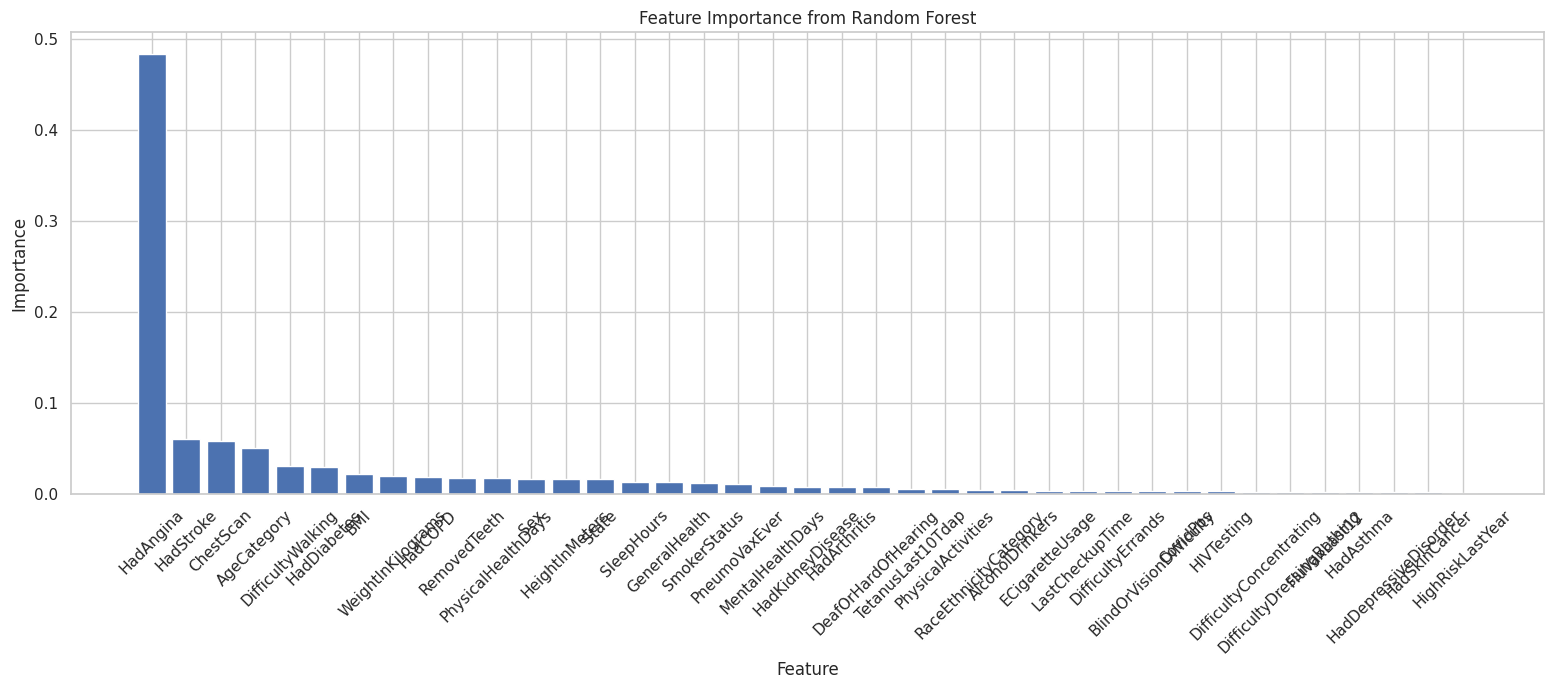

In [36]:
best_rf.fit(X_train_processed, y_train)

# Get feature importances
feature_importances = best_rf.feature_importances_

# Sort features in descending order of importance
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
feature_names = X_train_processed.columns

# Plot the feature importances
plt.figure(figsize=(19, 6))
plt.bar(range(X_train_processed.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_processed.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()